### Data preprocessing for homesale data
The feature engineering part is taken from Kaggle winner:
https://www.kaggle.com/code/sandeepkumar121995/blending-of-6-models-top-10/notebook


In [610]:
import numpy as np  # linear algebra
import pandas as pd  #
from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import os

import matplotlib.pyplot as plt

print(os.listdir("home_data"))

['test.csv.gz', 'sample_submission.csv.gz', 'test.csv', 'data_description.txt', 'train.csv', 'train.csv.gz', 'sample_submission.csv']


In [611]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 50)

In [612]:
'''use top performer's result as labels for test data'''
top_submission_saleprice = pd.read_csv('SalePrice_top_submission.csv')
top_submission_saleprice.head()

,id,SalePrice
0,1461,121390.504435
1,1462,161597.008073
2,1463,181572.678008
3,1464,198661.910814
4,1465,198232.723419


In [613]:
train = pd.read_csv('home_data/train.csv')
test = pd.read_csv('home_data/test.csv')
print("Train set size:", train.shape)
print("Test set size:", test.shape)

Train set size: (1460, 81)
Test set size: (1459, 80)


In [614]:
'''recover sale price for test data using online top result'''
test['SalePrice'] = top_submission_saleprice.SalePrice
# test['Id_'] = top_submission_saleprice.id
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,121390.504435
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,161597.008073
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,181572.678008
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,198661.910814
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,198232.723419


In [615]:
'''Concat train and join to get the complete dataset'''
data = pd.concat([train, test])
data.shape

(2919, 81)

In [616]:
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
data.drop(['Id'], axis=1, inplace=True)

In [617]:
# Deleting outliers
data = data[data.GrLivArea < 4500]
data.reset_index(drop=True, inplace=True)


In [618]:
# '''Reserve the original sale price for later categorization'''
# y_origin = data['SalePrice'].copy()

'''Because the original Kaggle preprocessing transform sale prices to log scale'''
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data["SalePrice"] = np.log1p(data["SalePrice"])
y = data.SalePrice.reset_index(drop=True)
features = data.drop(['SalePrice'], axis=1)


In [619]:
# features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)

(2916, 79)


In [620]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

features["PoolQC"] = features["PoolQC"].fillna("None")

In [621]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [622]:
# Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

In [623]:
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])


/Users/evantilu/miniforge3/envs/6998_DL_tf/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/evantilu/miniforge3/envs/6998_DL_tf/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4098: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [624]:
# simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


In [625]:
print(features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print(final_features.shape)


(2916, 86)
(2916, 333)


In [626]:
X = final_features
print('X', X.shape, 'y', y.shape)

X (2916, 333) y (2916,)


In [627]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])


In [628]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape)

X (2911, 321) y (2911,)


### bucketize sale prices for classification

In [629]:
# '''ver 1: three classes: low, mid, hi
# gnerate category sale price as new targete'''
# ### Note: this categorization must be applied only after y doesn't change anymore

# '''decide spiltting points'''

# quant_033 = y.quantile([0.33, 0.66]).loc[0.33]
# quant_066 = y.quantile([0.33, 0.66]).loc[0.66]

# print('(0.33, 0.66) quatiles: ({}, {})\n'.format(quant_033, quant_066))
# print('< 0.33 quantile: ', (y <= quant_033).sum())
# print('0.33~0.66 quantile: ', ((y > quant_033) & (y <= quant_066)).sum())
# print('>0.66 quantile: ', (y > quant_066).sum())

# '''split y into buckets'''

# y_cat = pd.cut(
#     x=y,
#     bins=[0, quant_033, quant_066, np.inf],
#     labels=["low", "mid", "hi"],
#     # labels=[0, 1, 2, 3],
# )

# print('\n\nAfter splitting...\n')
# print('y_cat.shape = ', y_cat.shape, '\n')
# print('category counts: \n', y_cat.value_counts())


In [630]:
'''ver : five classes: low, low-mid, mid, mid-hi, hi
gnerate category sale price as new targete'''
### Note: this categorization must be applied only after y doesn't change anymore

'''decide spiltting points'''

# quant_02 = y.quantile([0.2, 0.4, 0.6, 0.8]).loc[0.2]
# quant_04 = y.quantile([0.2, 0.4, 0.6, 0.8]).loc[0.4]
# quant_06 = y.quantile([0.2, 0.4, 0.6, 0.8]).loc[0.6]
# quant_08 = y.quantile([0.2, 0.4, 0.6, 0.8]).loc[0.8]

# print('(0.2, 0.4, 0.6, 0.8) quatiles: ({}, {})\n'.format(quant_02, quant_04, quant_06, quant_08))
# print('< 0.2 quantile: ', (y <= quant_02).sum())
# print('0.2~0.4 quantile: ', ((y > quant_02) & (y <= quant_04)).sum())
# print('0.4~0.6 quantile: ', ((y > quant_04) & (y <= quant_06)).sum())
# print('0.6~0.8 quantile: ', ((y > quant_06) & (y <= quant_08)).sum())
# print('>0.8 quantile: ', (y > quant_08).sum())

# '''split y into buckets'''

# y_cat = pd.cut(
#     x=y,
#     bins=[0, quant_02, quant_04, quant_06, quant_08, np.inf],
#     labels=["low", "low-mid", "mid", "mid-hi", "hi"],
# )

# print('\n\nAfter splitting...\n')
# print('y_cat.shape = ', y_cat.shape, '\n')
# print('category counts: \n', y_cat.value_counts())


'decide spiltting points'

In [631]:
'''ver : ten classes: p0 ~ p9 (p0 = highest price)
gnerate category sale price as new targete'''
### Note: this categorization must be applied only after y doesn't change anymore

'''decide spiltting points'''

quant_01 = y.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).loc[0.1]
quant_02 = y.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).loc[0.2]
quant_03 = y.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).loc[0.3]
quant_04 = y.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).loc[0.4]
quant_05 = y.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).loc[0.5]
quant_06 = y.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).loc[0.6]
quant_07 = y.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).loc[0.7]
quant_08 = y.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).loc[0.8]
quant_09 = y.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).loc[0.9]


'''split y into buckets'''
y_cat = pd.cut(
    x=y,
    bins=[0, quant_01, quant_02, quant_03, quant_04, quant_05, quant_06, quant_07, quant_08, quant_09, np.inf],
    labels=['p9', 'p8', 'p7', 'p6', 'p5', 'p4', 'p3', 'p2', 'p1', 'p0']
)

print('\n\nAfter splitting...\n')
print('y_cat.shape = ', y_cat.shape, '\n')
print('category counts:\n', y_cat.value_counts())




After splitting...

y_cat.shape =  (2911,) 

category counts:
 p7    304
p9    292
p8    291
p5    291
p4    291
p3    291
p2    291
p1    291
p0    291
p6    278
Name: SalePrice, dtype: int64


In [632]:
'''
Sort features according to correlation to sales price
'''

# join back sales price 
X['SalePrice'] = y

corr = X.corr()
corr.sort_values(['SalePrice'], ascending=False, inplace=True)

# sort columns by correlation
order = corr.index
X = X.loc[:, order]

# drop sales price from feature after done
X.drop(['SalePrice'], axis=1, inplace=True)

X.head()

,OverallQual,GrLivArea,TotalSF,GarageCars,Total_Bathrooms,GarageArea,YrBltAndRemod,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,Foundation_PConc,TotRmsAbvGrd,hasfireplace,ExterQual_Gd,BsmtQual_Ex,Fireplaces,HeatingQC_Ex,MasVnrArea,Total_porch_sf,BsmtFinType1_GLQ,KitchenQual_Ex,OpenPorchSF,GarageFinish_Fin,GarageType_Attchd,MSSubClass_60,KitchenQual_Gd,LotArea,ExterQual_Ex,BsmtFinSF1,Neighborhood_NridgHt,Exterior1st_VinylSd,WoodDeckSF,FireplaceQu_Gd,LotFrontage,Exterior2nd_VinylSd,CentralAir_Y,GarageCond_TA,Total_sqr_footage,PavedDrive_Y,GarageQual_TA,GarageYrBlt,SaleType_New,SaleCondition_Partial,BsmtQual_Gd,HalfBath,hasgarage,BsmtExposure_Gd,LotShape_IR1,...,Neighborhood_MeadowV,Exterior1st_MetalSd,Exterior1st_AsbShng,Neighborhood_NAmes,HeatingQC_Fa,ExterQual_Fa,BsmtCond_Fa,ExterCond_Fa,SaleCondition_Abnorml,Alley_Grvl,GarageCond_Fa,Exterior2nd_Wd Sdng,SaleType_WD,MSSubClass_50,EnclosedPorch,GarageQual_Fa,Exterior1st_Wd Sdng,KitchenQual_Fa,Neighborhood_Edwards,BsmtExposure_None,BsmtCond_None,BsmtFinType2_None,HouseStyle_1.5Fin,BsmtQual_Fa,BsmtFinType1_None,BsmtQual_None,RoofStyle_Gable,Electrical_FuseA,Neighborhood_IDOTRR,BsmtExposure_No,Neighborhood_OldTown,Foundation_BrkTil,GarageFinish_None,GarageCond_None,GarageQual_None,GarageType_None,MSSubClass_30,LotShape_Reg,PavedDrive_N,Foundation_CBlock,MSZoning_RM,HeatingQC_TA,CentralAir_N,GarageType_Detchd,MasVnrType_None,GarageFinish_Unf,BsmtQual_TA,FireplaceQu_None,KitchenQual_TA,ExterQual_TA
0,7,9.022979,1889.173829,2.0,3.527552,548.0,4006,856.0,6.782008,2003,2,2003,1,2.315789,0,1,0,0.000000,1,19.589646,12.172166,1,0,12.172166,0,1,1,1,13.919572,0,158.622104,0,1,0.000000,0,18.185234,1,1,1,1191.795933,1,1,2003.0,0,0,1,1.068579,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,6,8.585508,1269.173196,2.0,2.354861,460.0,3952,1262.0,7.173196,1976,2,1976,0,2.038529,1,0,0,0.903299,1,0.000000,56.388845,0,0,0.000000,0,1,0,0,14.207612,0,201.168316,0,0,56.388845,0,20.722751,0,1,1,208.341512,1,1,1976.0,0,0,1,0.000000,1,1,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1
2,7,9.086151,1968.128069,2.0,3.527552,608.0,4003,920.0,6.854643,2001,2,2002,1,2.038529,1,1,0,0.903299,1,17.905665,9.968407,1,0,9.968407,0,1,1,1,14.570268,0,120.758581,0,1,0.000000,0,18.710426,1,1,1,1168.886649,1,1,2001.0,0,0,1,1.068579,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,9.028908,1668.014783,3.0,1.993263,642.0,3885,756.0,6.898572,1915,1,1970,0,2.185435,1,0,0,0.903299,0,0.000000,25.048717,0,0,9.023656,0,0,0,1,14.195759,0,66.624742,0,0,0.000000,1,17.287417,0,1,1,978.639524,1,1,1998.0,0,0,0,0.000000,1,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,16.025061,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1
4,8,9.389617,2426.051299,3.0,3.527552,836.0,4000,1145.0,7.075118,2000,2,2000,1,2.433014,1,1,0,0.903299,1,25.636502,56.775327,1,0,14.390224,0,1,1,1,15.122076,0,150.175445,0,1,42.385103,0,21.365615,1,1,1,1431.226745,1,1,2000.0,0,0,1,1.068579,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [633]:
'''Scaling'''
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

'''robust scaler'''
# scaler = RobustScaler()
# X_scaled = scaler.fit_transform(X)

'''standard scaler'''
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

'''Minmax scale to 0~1'''
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = minmax_scaler.fit_transform(X)

# X_scaled.shape
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.describe()



,OverallQual,GrLivArea,TotalSF,GarageCars,Total_Bathrooms,GarageArea,YrBltAndRemod,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,Foundation_PConc,TotRmsAbvGrd,hasfireplace,ExterQual_Gd,BsmtQual_Ex,Fireplaces,HeatingQC_Ex,MasVnrArea,Total_porch_sf,BsmtFinType1_GLQ,KitchenQual_Ex,OpenPorchSF,GarageFinish_Fin,GarageType_Attchd,MSSubClass_60,KitchenQual_Gd,LotArea,ExterQual_Ex,BsmtFinSF1,Neighborhood_NridgHt,Exterior1st_VinylSd,WoodDeckSF,FireplaceQu_Gd,LotFrontage,Exterior2nd_VinylSd,CentralAir_Y,GarageCond_TA,Total_sqr_footage,PavedDrive_Y,GarageQual_TA,GarageYrBlt,SaleType_New,SaleCondition_Partial,BsmtQual_Gd,HalfBath,hasgarage,BsmtExposure_Gd,LotShape_IR1,...,Neighborhood_MeadowV,Exterior1st_MetalSd,Exterior1st_AsbShng,Neighborhood_NAmes,HeatingQC_Fa,ExterQual_Fa,BsmtCond_Fa,ExterCond_Fa,SaleCondition_Abnorml,Alley_Grvl,GarageCond_Fa,Exterior2nd_Wd Sdng,SaleType_WD,MSSubClass_50,EnclosedPorch,GarageQual_Fa,Exterior1st_Wd Sdng,KitchenQual_Fa,Neighborhood_Edwards,BsmtExposure_None,BsmtCond_None,BsmtFinType2_None,HouseStyle_1.5Fin,BsmtQual_Fa,BsmtFinType1_None,BsmtQual_None,RoofStyle_Gable,Electrical_FuseA,Neighborhood_IDOTRR,BsmtExposure_No,Neighborhood_OldTown,Foundation_BrkTil,GarageFinish_None,GarageCond_None,GarageQual_None,GarageType_None,MSSubClass_30,LotShape_Reg,PavedDrive_N,Foundation_CBlock,MSZoning_RM,HeatingQC_TA,CentralAir_N,GarageType_Detchd,MasVnrType_None,GarageFinish_Unf,BsmtQual_TA,FireplaceQu_None,KitchenQual_TA,ExterQual_TA
count,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,...,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000
mean,0.565136,0.542763,0.293431,0.353143,0.200863,0.317285,0.660811,0.326706,0.487996,0.719569,0.391876,0.570892,0.447956,0.542786,0.512882,0.335967,0.087255,0.171718,0.511508,0.159954,0.203170,0.290622,0.069392,0.176542,0.245620,0.590519,0.196840,0.395053,0.325982,0.035727,0.259335,0.057025,0.352113,0.128559,0.254208,0.254736,0.348334,0.933356,0.909653,0.173217,0.905187,0.892133,0.847636,0.080728,0.082789,0.415321,0.182093,0.946067,0.093782,0.331158,...,0.012710,0.154243,0.015115,0.152181,0.031604,0.011680,0.035383,0.022329,0.064926,0.041223,0.025077,0.134318,0.866712,0.098248,0.071577,0.042597,0.141189,0.023703,0.065613,0.028169,0.028169,0.027482,0.107523,0.030230,0.027138,0.027825,0.792855,0.064583,0.031261,0.652697,0.082102,0.106493,0.054277,0.054277,0.054277,0.053590,0.047750,0.637582,0.073514,0.423222,0.158708,0.293370,0.066644,0.266919,0.605634,0.421848,0.439368,0.487118,0.511852,0.616627
std,0.155988,0.125193,0.119772,0.152244,0.133043,0.143976,0.242686,0.131930,0.131369,0.219351,0.138140,0.348189,0.497369,0.128554,0.499920,0.472409,0.282257,0.181727,0.499953,0.218350,0.163524,0.454127,0.254163,0.183129,0.430528,0.491823,0.397678,0.488946,0.092325,0.185639,0.230262,0.231930,0.477711,0.151029,0.435490,0.093097,0.476524,0.249447,0.286727,0.175354,0.293006,0.310265,0.203412,0.272464,0.27561

In [634]:
'''
add 3 dummny features to make it 18*18 for CNN
padding to make it a perfect square, 324
'''

X_scaled_df['dummy_1'] = 0.0
X_scaled_df['dummy_2'] = 0.0
X_scaled_df['dummy_3'] = 0.0

In [635]:
'''cast to flaot32 (originally float64)'''
X_scaled_df = X_scaled_df.astype(dtype='float32')
print(X_scaled_df.dtypes)
X_scaled_df.head()

OverallQual             float32
GrLivArea               float32
TotalSF                 float32
GarageCars              float32
Total_Bathrooms         float32
GarageArea              float32
YrBltAndRemod           float32
TotalBsmtSF             float32
1stFlrSF                float32
YearBuilt               float32
FullBath                float32
YearRemodAdd            float32
Foundation_PConc        float32
TotRmsAbvGrd            float32
hasfireplace            float32
ExterQual_Gd            float32
BsmtQual_Ex             float32
Fireplaces              float32
HeatingQC_Ex            float32
MasVnrArea              float32
Total_porch_sf          float32
BsmtFinType1_GLQ        float32
KitchenQual_Ex          float32
OpenPorchSF             float32
GarageFinish_Fin        float32
                         ...   
Neighborhood_IDOTRR     float32
BsmtExposure_No         float32
Neighborhood_OldTown    float32
Foundation_BrkTil       float32
GarageFinish_None       float32
GarageCo

,OverallQual,GrLivArea,TotalSF,GarageCars,Total_Bathrooms,GarageArea,YrBltAndRemod,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,Foundation_PConc,TotRmsAbvGrd,hasfireplace,ExterQual_Gd,BsmtQual_Ex,Fireplaces,HeatingQC_Ex,MasVnrArea,Total_porch_sf,BsmtFinType1_GLQ,KitchenQual_Ex,OpenPorchSF,GarageFinish_Fin,GarageType_Attchd,MSSubClass_60,KitchenQual_Gd,LotArea,ExterQual_Ex,BsmtFinSF1,Neighborhood_NridgHt,Exterior1st_VinylSd,WoodDeckSF,FireplaceQu_Gd,LotFrontage,Exterior2nd_VinylSd,CentralAir_Y,GarageCond_TA,Total_sqr_footage,PavedDrive_Y,GarageQual_TA,GarageYrBlt,SaleType_New,SaleCondition_Partial,BsmtQual_Gd,HalfBath,hasgarage,BsmtExposure_Gd,LotShape_IR1,...,Neighborhood_NAmes,HeatingQC_Fa,ExterQual_Fa,BsmtCond_Fa,ExterCond_Fa,SaleCondition_Abnorml,Alley_Grvl,GarageCond_Fa,Exterior2nd_Wd Sdng,SaleType_WD,MSSubClass_50,EnclosedPorch,GarageQual_Fa,Exterior1st_Wd Sdng,KitchenQual_Fa,Neighborhood_Edwards,BsmtExposure_None,BsmtCond_None,BsmtFinType2_None,HouseStyle_1.5Fin,BsmtQual_Fa,BsmtFinType1_None,BsmtQual_None,RoofStyle_Gable,Electrical_FuseA,Neighborhood_IDOTRR,BsmtExposure_No,Neighborhood_OldTown,Foundation_BrkTil,GarageFinish_None,GarageCond_None,GarageQual_None,GarageType_None,MSSubClass_30,LotShape_Reg,PavedDrive_N,Foundation_CBlock,MSZoning_RM,HeatingQC_TA,CentralAir_N,GarageType_Detchd,MasVnrType_None,GarageFinish_Unf,BsmtQual_TA,FireplaceQu_None,KitchenQual_TA,ExterQual_TA,dummy_1,dummy_2,dummy_3
0,0.666667,0.613756,0.380453,0.4,0.415298,0.368280,0.926316,0.266999,0.385529,0.949275,0.50,0.883333,1.0,0.674300,0.0,1.0,0.0,0.000000,1.0,0.386438,0.079117,1.0,0.0,0.287892,0.0,1.0,1.0,1.0,0.314535,0.0,0.424849,0.0,1.0,0.000000,0.0,0.241017,1.0,1.0,1.0,0.408309,1.0,1.0,0.907567,0.0,0.0,1.0,0.477837,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.555556,0.495663,0.255207,0.4,0.223127,0.309140,0.642105,0.393637,0.544832,0.753623,0.50,0.433333,0.0,0.516936,1.0,0.0,0.0,0.293793,1.0,0.000000,0.366518,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.337959,0.0,0.538804,0.0,0.0,0.366518,0.0,0.305766,0.0,1.0,1.0,0.069720,1.0,1.0,0.895333,0.0,0.0,1.0,0.000000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.666667,0.630809,0.396403,0.4,0.415298,0.408602,0.910526,0.286962,0.415108,0.934783,0.50,0.866667,1.0,0.516936,1.0,1.0,0.0,0.293793,1.0,0.353218,0.064793,1.0,0.0,0.235769,0.0,1.0,1.0,1.0,0.367451,0.0,0.323436,0.0,1.0,0.000000,0.0,0.254418,1.0,1.0,1.0,0.400422,1.0,1.0,0.906661,0.0,0.0,1.0,0.477837,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.666667,0.615357,0.335777,0.6,0.163872,0.431452,0.289474,0.235808,0.432997,0.311594,0.25,0.333333,0.0,0.600315,1.0,0.0,0.0,0.293793,0.0,0.000000,0.162812,0.0,0.0,0.213424,0.0,0.0,0.0,1.0,0.336995,0.0,0.178446,0.0,0.0,0.000000,1.0,0.218108,0.0,1.0,1.0,0.334922,1.0,1.0,0.905301,0.0,0.0,0.0,0.000000,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.611521,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.777778,0.712728,0.488908,0.6,0.415298,0.561828,0.894737,0.357143,0.504892,0.927536,0.50,0.833333,1.0,0.740833,1.0,1.0,0.0,0.293793,1.0,0.505722,0.369030,1.0,0.0,0.340353,0.0,1.0,1.0,1.0,0.412325,0.0,0.402226,0.0,1.0,0.275496,0.0,0.322170,1.0,1.0,1.0,0.490741,1.0,1.0,0.906208,0.0,0.0,1.0,0.477837,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [636]:
'''export as csv'''
# append the label column
X_scaled_df['label'] = y_cat.reset_index().drop(['index'], axis=1)
X_scaled_df.to_csv('../data/home_sale_data_324_features_10_class.csv', index=False)

In [637]:
'''test reading'''
df = pd.read_csv('../data/home_sale_data_324_features_10_class.csv')
df.head()

,OverallQual,GrLivArea,TotalSF,GarageCars,Total_Bathrooms,GarageArea,YrBltAndRemod,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,Foundation_PConc,TotRmsAbvGrd,hasfireplace,ExterQual_Gd,BsmtQual_Ex,Fireplaces,HeatingQC_Ex,MasVnrArea,Total_porch_sf,BsmtFinType1_GLQ,KitchenQual_Ex,OpenPorchSF,GarageFinish_Fin,GarageType_Attchd,MSSubClass_60,KitchenQual_Gd,LotArea,ExterQual_Ex,BsmtFinSF1,Neighborhood_NridgHt,Exterior1st_VinylSd,WoodDeckSF,FireplaceQu_Gd,LotFrontage,Exterior2nd_VinylSd,CentralAir_Y,GarageCond_TA,Total_sqr_footage,PavedDrive_Y,GarageQual_TA,GarageYrBlt,SaleType_New,SaleCondition_Partial,BsmtQual_Gd,HalfBath,hasgarage,BsmtExposure_Gd,LotShape_IR1,...,HeatingQC_Fa,ExterQual_Fa,BsmtCond_Fa,ExterCond_Fa,SaleCondition_Abnorml,Alley_Grvl,GarageCond_Fa,Exterior2nd_Wd Sdng,SaleType_WD,MSSubClass_50,EnclosedPorch,GarageQual_Fa,Exterior1st_Wd Sdng,KitchenQual_Fa,Neighborhood_Edwards,BsmtExposure_None,BsmtCond_None,BsmtFinType2_None,HouseStyle_1.5Fin,BsmtQual_Fa,BsmtFinType1_None,BsmtQual_None,RoofStyle_Gable,Electrical_FuseA,Neighborhood_IDOTRR,BsmtExposure_No,Neighborhood_OldTown,Foundation_BrkTil,GarageFinish_None,GarageCond_None,GarageQual_None,GarageType_None,MSSubClass_30,LotShape_Reg,PavedDrive_N,Foundation_CBlock,MSZoning_RM,HeatingQC_TA,CentralAir_N,GarageType_Detchd,MasVnrType_None,GarageFinish_Unf,BsmtQual_TA,FireplaceQu_None,KitchenQual_TA,ExterQual_TA,dummy_1,dummy_2,dummy_3,label
0,0.666667,0.613756,0.380453,0.4,0.415298,0.368280,0.926316,0.266999,0.385529,0.949275,0.50,0.883333,1.0,0.674300,0.0,1.0,0.0,0.000000,1.0,0.386438,0.079117,1.0,0.0,0.287892,0.0,1.0,1.0,1.0,0.314535,0.0,0.424849,0.0,1.0,0.000000,0.0,0.241017,1.0,1.0,1.0,0.408309,1.0,1.0,0.907567,0.0,0.0,1.0,0.477837,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,p2
1,0.555556,0.495663,0.255207,0.4,0.223127,0.309140,0.642105,0.393637,0.544832,0.753623,0.50,0.433333,0.0,0.516936,1.0,0.0,0.0,0.293793,1.0,0.000000,0.366518,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.337959,0.0,0.538804,0.0,0.0,0.366518,0.0,0.305766,0.0,1.0,1.0,0.069720,1.0,1.0,0.895333,0.0,0.0,1.0,0.000000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,p3
2,0.666667,0.630809,0.396403,0.4,0.415298,0.408602,0.910526,0.286962,0.415108,0.934783,0.50,0.866667,1.0,0.516936,1.0,1.0,0.0,0.293793,1.0,0.353218,0.064793,1.0,0.0,0.235769,0.0,1.0,1.0,1.0,0.367451,0.0,0.323437,0.0,1.0,0.000000,0.0,0.254418,1.0,1.0,1.0,0.400421,1.0,1.0,0.906661,0.0,0.0,1.0,0.477837,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,p2
3,0.666667,0.615356,0.335777,0.6,0.163872,0.431452,0.289474,0.235808,0.432997,0.311594,0.25,0.333333,0.0,0.600315,1.0,0.0,0.0,0.293793,0.0,0.000000,0.162812,0.0,0.0,0.213424,0.0,0.0,0.0,1.0,0.336995,0.0,0.178446,0.0,0.0,0.000000,1.0,0.218108,0.0,1.0,1.0,0.334922,1.0,1.0,0.905301,0.0,0.0,0.0,0.000000,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.611521,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,p6
4,0.777778,0.712728,0.488908,0.6,0.415298,0.561828,0.894737,0.357143,0.504892,0.927536,0.50,0.833333,1.0,0.740833,1.0,1.0,0.0,0.293793,1.0,0.505722,0.369030,1.0,0.0,0.340353,0.0,1.0,1.0,1.0,0.412325,0.0,0.402226,0.0,1.0,0.275496,0.0,0.322170,1.0,1.0,1.0,0.490741,1.0,1.0,0.906208,0.0,0.0,1.0,0.477837,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

#### Visualize the "images"

Text(0.5, 0.98, 'Housing sale images and labels')

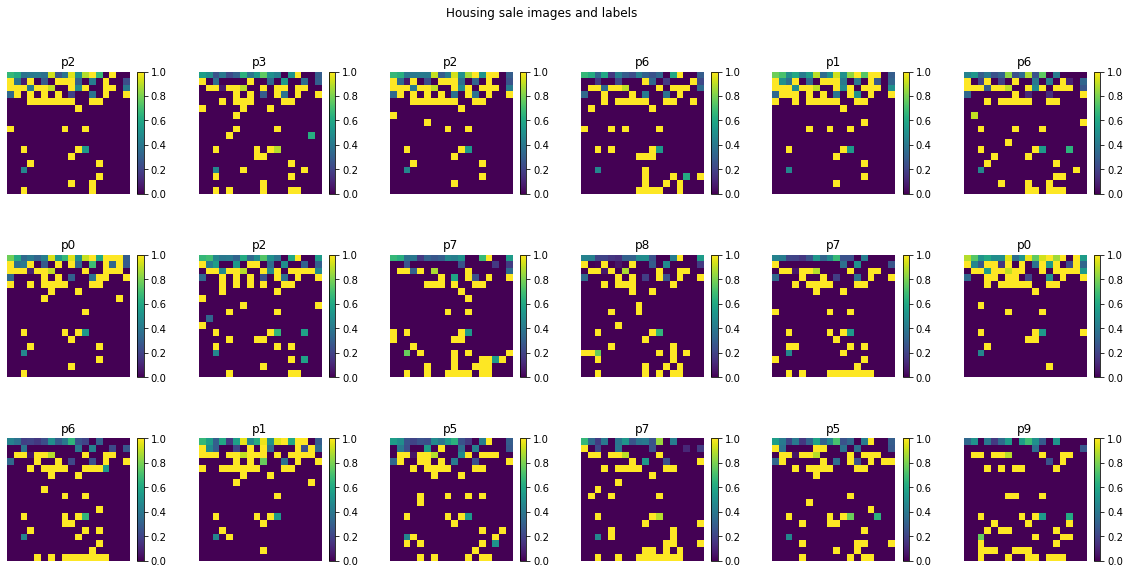

In [638]:
'''plot multiple images and show labels'''
plt.figure(figsize=(20,9))
plt.subplots_adjust(hspace=0.5)

for n in range(18):
    img = X_scaled_df.iloc[n, :-1]
    img = np.array(img, dtype = 'float32')
    img=img.reshape(18, 18)

    plt.subplot(3,6,n+1)
    plt.imshow(img, cmap=plt.cm.viridis, vmax=1, vmin=0)
    plt.title(y_cat[n])
    plt.colorbar()
    plt.axis('off')

plt.suptitle("Housing sale images and labels")

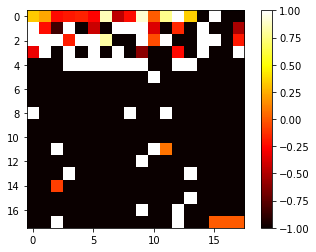

In [118]:
'''plot a single image'''
nArray = np.array(X_scaled_df.iloc[0, :], dtype='float32')
nArray=nArray.reshape(18, 18)

plt.imshow(nArray, cmap='hot')
plt.colorbar()
plt.show()

### Some other tests

In [251]:
img.shape

(18, 18)

In [252]:
np.asarray(img)

array([[0.5568628 , 0.627451  , 0.4       , 0.2509804 , 0.32156864,
        0.7372549 , 0.27058825, 0.44705883, 0.81960785, 0.49803922,
        0.58431375, 0.35686275, 0.        , 0.6117647 , 1.        ,
        1.        , 0.29803923, 0.        ],
       [0.        , 0.49803922, 0.34509805, 0.        , 0.        ,
        0.24705882, 1.        , 1.        , 1.        , 1.        ,
        0.30588236, 0.        , 0.        , 0.        , 0.        ,
        0.2784314 , 0.        , 0.        ],
       [1.        , 0.28235295, 1.        , 0.31764707, 1.        ,
        1.        , 0.8980392 , 0.        , 0.        , 1.        ,
        0.47843137, 1.        , 0.        , 0.        , 1.        ,
        1.        , 0.        , 0.35686275],
       [0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.50980395,
        0.        , 1.        , 0.3764706 , 0.        , 1.        ,
        0.        , 0.        , 1.        ],
    

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


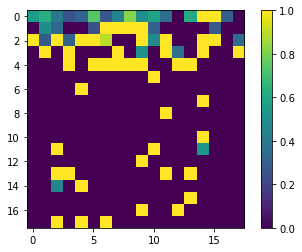

In [250]:
# nArray = np.reshape(nArray, (18, 18, 1))

# plt.imsave('test1.png', nArray, cmap='gray')



from PIL import Image

# Make PIL Image from Numpy array
# pImage = Image.fromarray(nArray)
# pImage.save('pil.jpeg')

import imageio
import numpy as np

# array = np.arange(0, 737280, 1, np.uint8)
# array = np.reshape(array, (1024, 720))

imageio.imwrite('test1.png', nArray)

img = plt.imread('test1.png')
plt.imshow(img)
plt.colorbar()
plt.show()

In [172]:
tmp_df = X_scaled_df.drop(['label'], axis=1)
tmp = tmp_df.iloc[0]
tmpnp = tmp.to_numpy()
tmpnp = np.reshape(tmpnp, (18, 18))
plt.imsave('test.png', tmpnp)

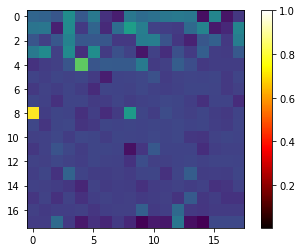

In [175]:
img = plt.imread('test.png')
plt.imshow(img, cmap='hot')
plt.colorbar()
plt.show()

In [ ]:
'''Try saving as an image'''
plt.imsave('test.jpeg', X[0])